In [96]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [91]:
positiveFiles = [x for x in os.listdir("movie_reviews/train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir("movie_reviews/train/neg/") if x.endswith(".txt")]
testFiles = [x for x in os.listdir("movie_reviews/test/") if x.endswith(".txt")]
testScores = genfromtxt('test_rating.csv', delimiter=',', skip_header=1)
positiveReviews, negativeReviews, testReviews = [], [], []
for pfile in positiveFiles:
    with open("movie_reviews/train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open("movie_reviews/train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for review in testScores:
    with open("movie_reviews/test/" + str(int(review[0])) + '.txt', encoding="latin1") as f:
        testReviews.append(f.read())

In [92]:
print(len(positiveReviews))
print(len(negativeReviews))
print(len(testReviews))
print(len(testScores))

12500
12500
25000
25000


Review length: 
Mean 1315.90 words (1001.387664)


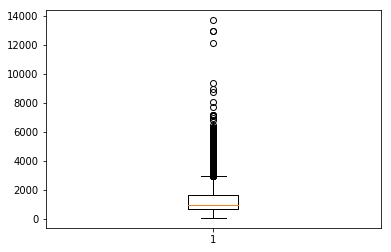

In [93]:
allTrainReviews = positiveReviews + negativeReviews
print("Review length: ")
result = [len(x) for x in allTrainReviews]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [94]:
# 1 - pos
# 2 - neg
train_Y = [[1]] * len(positiveReviews) + [[0]] * len(negativeReviews)
test_Y = []
for item in my_data:
    if int(item[1]) >= 7:
        test_Y.append(1)
    elif int(item[1]) <= 4:
        test_Y.append(0)

In [95]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

allTrainReviews = list(map(lambda x: x.lower(), allTrainReviews))
testFiles = list(map(lambda x: x.lower(), testFiles))

train_X = allTrainReviews
test_X = testFiles
X = train_X + test_X
train_Y = to_categorical(train_Y)
test_Y = to_categorical(test_Y)

max_words = 10000
maxlen = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=maxlen)
train_X = tokenizer.texts_to_sequences(train_X)
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = tokenizer.texts_to_sequences(test_X)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [103]:
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 502       
Total params: 2,323,856
Trainable params: 2,323,856
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=10, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(test_X, test_Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
 - 16s - loss: 0.1071 - acc: 0.9637 - val_loss: 0.6972 - val_acc: 0.5000
Epoch 2/10
 - 15s - loss: 0.0465 - acc: 0.9875 - val_loss: 0.6979 - val_acc: 0.4999
Epoch 3/10
 - 15s - loss: 0.0148 - acc: 0.9978 - val_loss: 0.7001 - val_acc: 0.5000
Epoch 4/10
 - 15s - loss: 0.0042 - acc: 0.9996 - val_loss: 0.7002 - val_acc: 0.5000
Epoch 5/10
 - 15s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.7015 - val_acc: 0.5000
Epoch 6/10
 - 15s - loss: 4.3821e-04 - acc: 1.0000 - val_loss: 0.7045 - val_acc: 0.5000
Epoch 7/10
 - 15s - loss: 2.3716e-04 - acc: 1.0000 - val_loss: 0.7080 - val_acc: 0.5000
Epoch 8/10
 - 15s - loss: 1.2895e-04 - acc: 1.0000 - val_loss: 0.7153 - val_acc: 0.5000
Epoch 9/10
 - 15s - loss: 6.3834e-05 - acc: 1.0000 - val_loss: 0.7216 - val_acc: 0.5000
Epoch 10/10
 - 15s - loss: 3.4250e-05 - acc: 1.0000 - val_loss: 0.7320 - val_acc: 0.4999
Accuracy: 49.99%


In [109]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [ ]:
vocab_size = max_words+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

In [112]:
import pandas as pd
import nltk, re, time
from nltk.corpus import stopwords
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import namedtuple

In [131]:
def lstm_cell(lstm_size, keep_prob):
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    return drop

def build_rnn(n_words, embed_size, batch_size, lstm_size, num_layers, dropout, learning_rate, multiple_fc, fc_units):
    '''Build the Recurrent Neural Network'''

    tf.reset_default_graph()

    # Declare placeholders we'll feed into the graph
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.int32, [None, None], name='inputs')

    with tf.name_scope('labels'):
        labels = tf.placeholder(tf.int32, [None, None], name='labels')

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    # Create the embeddings
    with tf.name_scope("embeddings"):
        embedding = tf.Variable(tf.random_uniform((n_words, 
                                    embed_size), -1, 1))
        embed = tf.nn.embedding_lookup(embedding, inputs)

    # Build the RNN layers
    with tf.name_scope("RNN_layers"):
        cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(lstm_size, keep_prob) for _ in range(num_layers)])
    
    # Set the initial state
    with tf.name_scope("RNN_init_state"):
        initial_state = cell.zero_state(batch_size, tf.float32)

    # Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(
                                        cell,         
                                        embed,
                                        initial_state=initial_state)    
    
    # Create the fully connected layers
    with tf.name_scope("fully_connected"):
        
        # Initialize the weights and biases
        weights = tf.truncated_normal_initializer(stddev=0.1)
        biases = tf.zeros_initializer()
        
        dense = tf.contrib.layers.fully_connected(outputs[:, -1],
                    num_outputs = fc_units,
                    activation_fn = tf.sigmoid,
                    weights_initializer = weights,
                    biases_initializer = biases)
        
        dense = tf.contrib.layers.dropout(dense, keep_prob)
        
        # Depending on the iteration, use a second fully connected layer
        if multiple_fc == True:
            dense = tf.contrib.layers.fully_connected(dense,
                        num_outputs = fc_units,
                        activation_fn = tf.sigmoid,
                        weights_initializer = weights,
                        biases_initializer = biases)
            
            dense = tf.contrib.layers.dropout(dense, keep_prob)
    
    # Make the predictions
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(dense, 
                          num_outputs = 1, 
                          activation_fn=tf.sigmoid,
                          weights_initializer = weights,
                          biases_initializer = biases)
        
        tf.summary.histogram('predictions', predictions)
    
    # Calculate the cost
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels, predictions)
        tf.summary.scalar('cost', cost)
    
    # Train the model
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Determine the accuracy
    with tf.name_scope("accuracy"):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), 
                                        tf.int32), 
                                        labels)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'keep_prob','initial_state',        
                    'final_state','accuracy', 'predictions', 'cost', 
                    'optimizer', 'merged']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [132]:
word_index = tokenizer.word_index
n_words = len(word_index)
embed_size = 300
batch_size = 250
lstm_size = 128
num_layers = 2
dropout = 0.5
learning_rate = 0.001
epochs = 100
multiple_fc = False
fc_units = 256

In [133]:
def train(model, epochs, log_string):
    '''Train the RNN'''

    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        valid_loss_summary = []
        
        # Keep track of which batch iteration is being trained
        iteration = 0

        print()
        print("Training Model: {}".format(log_string))

        train_writer = tf.summary.FileWriter('./logs/3/train/{}'.format(log_string), sess.graph)
        valid_writer = tf.summary.FileWriter('./logs/3/valid/{}'.format(log_string))

        for e in range(epochs):
            state = sess.run(model.initial_state)
            
            # Record progress with each epoch
            train_loss = []
            train_acc = []
            val_acc = []
            val_loss = []

            with tqdm(total=len(train_X)) as pbar:
                for _, (x, y) in enumerate(get_batches(train_X,       
                                               train_Y, 
                                               batch_size), 1):
                    feed = {model.inputs: x,
                            model.labels: y[:, None],
                            model.keep_prob: dropout,
                            model.initial_state: state}
                    summary, loss, acc, state, _ = sess.run([model.merged, 
                                                  model.cost, 
                                                  model.accuracy, 
                                                  model.final_state, 
                                                  model.optimizer], 
                                                  feed_dict=feed)                
                    
                    # Record the loss and accuracy of each training batch
                    
                    train_loss.append(loss)
                    train_acc.append(acc)
                    
                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)
                    
                    iteration += 1
                    pbar.update(batch_size)
            
            # Average the training loss and accuracy of each epoch
            avg_train_loss = np.mean(train_loss)
            avg_train_acc = np.mean(train_acc) 

            val_state = sess.run(model.initial_state)
            with tqdm(total=len(x_valid)) as pbar:
                for x, y in get_batches(x_valid,y_valid,batch_size):
                    feed = {model.inputs: x,
                            model.labels: y[:, None],
                            model.keep_prob: 1,
                            model.initial_state: val_state}
                    summary, batch_loss, batch_acc, val_state = sess.run([model.merged, 
                                           model.cost, 
                                           model.accuracy, 
                                           model.final_state], 
                                           feed_dict=feed)
                    
                    # Record the validation loss and accuracy of each epoch
                    
                    val_loss.append(batch_loss)
                    val_acc.append(batch_acc)
                    pbar.update(batch_size)
            
            # Average the validation loss and accuracy of each epoch
            avg_valid_loss = np.mean(val_loss)    
            avg_valid_acc = np.mean(val_acc)
            valid_loss_summary.append(avg_valid_loss)
            
            # Record the validation data's progress
            valid_writer.add_summary(summary, iteration)

            # Print the progress of each epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train Loss: {:.3f}".format(avg_train_loss),
                  "Train Acc: {:.3f}".format(avg_train_acc),
                  "Valid Loss: {:.3f}".format(avg_valid_loss),
                  "Valid Acc: {:.3f}".format(avg_valid_acc))

            # Stop training if the validation loss does not decrease after 3 epochs
            
            if avg_valid_loss > min(valid_loss_summary):
                print("No Improvement.")
                stop_early += 1
                if stop_early == 3:
                    break   
            
            # Reset stop_early if the validation loss finds a new low
            # Save a checkpoint of the model
            else:
                print("New Record!")
                stop_early = 0
                checkpoint ="./sentiment_{}.ckpt".format(log_string)
                saver.save(sess, checkpoint)

In [135]:
def get_batches(x, y, batch_size):
    '''Create the batches for the training and validation data'''
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]
def get_test_batches(x, batch_size):
    '''Create the batches for the testing data'''
    n_batches = len(x)//batch_size
    x = x[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size]

In [ ]:
for lstm_size in [64,128]:
    for multiple_fc in [True, False]:
        for fc_units in [128, 256]:
            log_string = 'ru={},fcl={},fcu={}'.format(lstm_size,
                                                      multiple_fc,
                                                      fc_units)
            model = build_rnn(n_words = n_words, 
                              embed_size = embed_size,
                              batch_size = batch_size,
                              lstm_size = lstm_size,
                              num_layers = num_layers,
                              dropout = dropout,
                              learning_rate = learning_rate,
                              multiple_fc = multiple_fc,
                              fc_units = fc_units)            
            train(model, epochs, log_string)

In [137]:
def make_predictions(lstm_size, multiple_fc, fc_units, checkpoint):
    '''Predict the sentiment of the testing data'''
    
    # Record all of the predictions
    all_preds = []

    model = build_rnn(n_words = n_words, 
                      embed_size = embed_size,
                      batch_size = batch_size,
                      lstm_size = lstm_size,
                      num_layers = num_layers,
                      dropout = dropout,
                      learning_rate = learning_rate,
                      multiple_fc = multiple_fc,
                      fc_units = fc_units) 
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        # Load the model
        saver.restore(sess, checkpoint)
        test_state = sess.run(model.initial_state)
        for _, x in enumerate(get_test_batches(test_X, 
                                               batch_size), 1):
            feed = {model.inputs: x,
                    model.keep_prob: 1,
                    model.initial_state: test_state}
            predictions = sess.run(model.predictions,feed_dict=feed)
            for pred in predictions:
                all_preds.append(float(pred))
                
    return all_preds